
# Objective
The purpose of this product is to provide an automated service that recommends leads to a user given their current customer list (Portfolio).

# Context
Some companies would like to know who are the other companies in a given market (population) that are most likely to become their next customers. That is, your solution must find in the market who are the most adherent leads given the characteristics of the customers present in the user's portfolio.

In addition, your solution must be agnostic to the user. Any user with a list of customers who want to explore this market can extract value from the service.

For the challenge, the following bases should be considered:

Market: Base with information about the companies in the market to be considered. Portfolio 1: Company customer ids 1 Portfolio 2: Company customer ids 2 Portfolio 3: Company customer ids 3

Note: all companies (ids) in the portfolios are contained in the market (population base).


In [1]:
# Import libraries necessary for this project
from math import sqrt
from time import time

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [2]:
# Image settings for visualization
from IPython.core.pylabtools import figsize

figsize(12, 9)

sns.set()

In [3]:
# load the cleaned dataset
market = pd.read_csv('market_cleaned.csv')
market.head()

,id,sg_uf,natureza_juridica_macro,de_ramo,setor,fl_rm,nm_segmento,sg_uf_matriz,de_saude_tributaria,de_nivel_atividade,nm_meso_regiao,de_faixa_faturamento_estimado,qt_socios
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,4,2,11,2,1,10,20,5,4,6,2,2.0
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,3,5,21,5,1,3,17,2,2,4,10,1.0
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,1,5,32,5,1,21,2,3,3,2,1,1.0
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,1,5,25,5,1,18,2,3,3,2,10,1.0
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,4,5,27,5,1,8,20,5,4,6,10,1.0


In [4]:
aux_market = market.drop(columns=['id']) 

In [5]:
aux_market.isna().sum()

sg_uf                            0
natureza_juridica_macro          0
de_ramo                          0
setor                            0
fl_rm                            0
nm_segmento                      0
sg_uf_matriz                     0
de_saude_tributaria              0
de_nivel_atividade               0
nm_meso_regiao                   0
de_faixa_faturamento_estimado    0
qt_socios                        0
dtype: int64

In [6]:
def optimal_number_of_clusters(wcss):
    """ Find the optimal number of clusters for the K-means algorithm based on a dataset
    
    Args:
    wcss: list
    
    Return:
    
    Number of clusters
    """
    x1, y1 = 1, wcss[0]
    x2, y2 = 19, wcss[len(wcss)-1]
    distances = []
    for i in range(len(wcss)):
        x0 = i + 1
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 1

In [ ]:
# Using the Elbow Method to find the optimal number of clusters
X = aux_market
wcss = []
start = time()
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()
end= time()
print(f'Time of processing {round(end-start,3)} s')

In [ ]:
print(optimal_number_of_clusters(wcss))

## Taking a look in the Portfolios

### Portfolio 1

In [7]:
portfolio1 = pd.read_csv('portfolio1.csv')

In [8]:
portfolio1.head(1)

,Unnamed: 0,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,0,dabe79bec87c88ae04e869bf6bd321ee5e1893cecf6625...,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,COMERCIO VAREJISTA,COMERCIO,0.646575,<= 1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


We can see that the Portfolio1 has all columns and is not encoded yet.

In [9]:
# removing dropping all columns but ID from the dataset
portfolio1 = portfolio1.drop(columns=['Unnamed: 0'])
portfolio1 = portfolio1.drop(portfolio1.columns[1:], axis = 1)

In [10]:
# Merging Portfolio1 with the cleaned dataset
portfolio1 = portfolio1.merge(market, on='id', how='inner')

In [11]:
#chekcing it again
portfolio1.head(1)

,id,sg_uf,natureza_juridica_macro,de_ramo,setor,fl_rm,nm_segmento,sg_uf_matriz,de_saude_tributaria,de_nivel_atividade,nm_meso_regiao,de_faixa_faturamento_estimado,qt_socios
0,dabe79bec87c88ae04e869bf6bd321ee5e1893cecf6625...,3,5,5,1,0,9,17,2,2,15,10,1.0


In [12]:
portfolio1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 555 entries, 0 to 554
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             555 non-null    object 
 1   sg_uf                          555 non-null    int64  
 2   natureza_juridica_macro        555 non-null    int64  
 3   de_ramo                        555 non-null    int64  
 4   setor                          555 non-null    int64  
 5   fl_rm                          555 non-null    int64  
 6   nm_segmento                    555 non-null    int64  
 7   sg_uf_matriz                   555 non-null    int64  
 8   de_saude_tributaria            555 non-null    int64  
 9   de_nivel_atividade             555 non-null    int64  
 10  nm_meso_regiao                 555 non-null    int64  
 11  de_faixa_faturamento_estimado  555 non-null    int64  
 12  qt_socios                      555 non-null    flo

In [174]:
# let's set a function to visualize the portfolio's features so that we don't get redundant
def visualize_portfolio(portfolio,columns):
    for i in range(len(columns)):
        ax=plt.subplot(3, 4, i+1)
        sns.countplot(portfolio[columns[i]])

        ax.set_title(columns[i])
        ax.set_xlabel('')
        ax.set_ylabel('')
    plt.tight_layout()

In [56]:
# we need to remove the id column of the list
columns1 = portfolio1.columns[1:]

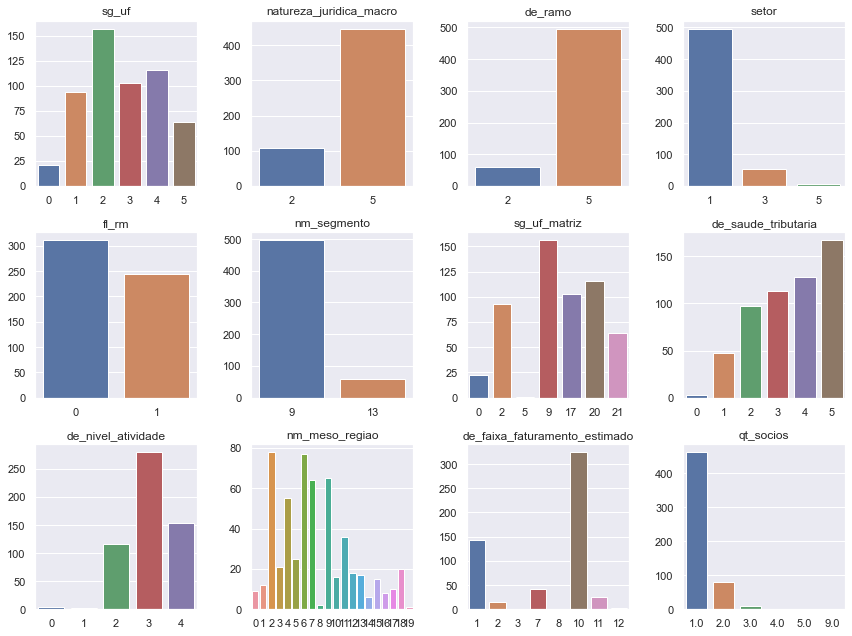

In [175]:
visualize_portfolio(portfolio1, columns1)

### Portfolio2

In [61]:
# I've already checked that portfolio2 and portfolio3 only have the id column
portfolio2 = pd.read_csv('portfolio2.csv').merge(market, on='id', how='inner')
portfolio2 = portfolio2.drop(portfolio2.columns[0], axis = 1)

In [62]:
portfolio2.head(1)

,id,sg_uf,natureza_juridica_macro,de_ramo,setor,fl_rm,nm_segmento,sg_uf_matriz,de_saude_tributaria,de_nivel_atividade,nm_meso_regiao,de_faixa_faturamento_estimado,qt_socios
0,09e95c1a84049001d086470a8f320a19b076f955a89122...,0,0,0,5,0,0,0,5,4,18,6,1.0


In [63]:
portfolio2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566 entries, 0 to 565
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             566 non-null    object 
 1   sg_uf                          566 non-null    int64  
 2   natureza_juridica_macro        566 non-null    int64  
 3   de_ramo                        566 non-null    int64  
 4   setor                          566 non-null    int64  
 5   fl_rm                          566 non-null    int64  
 6   nm_segmento                    566 non-null    int64  
 7   sg_uf_matriz                   566 non-null    int64  
 8   de_saude_tributaria            566 non-null    int64  
 9   de_nivel_atividade             566 non-null    int64  
 10  nm_meso_regiao                 566 non-null    int64  
 11  de_faixa_faturamento_estimado  566 non-null    int64  
 12  qt_socios                      566 non-null    flo

In [64]:
columns2 = portfolio2.columns[1:]

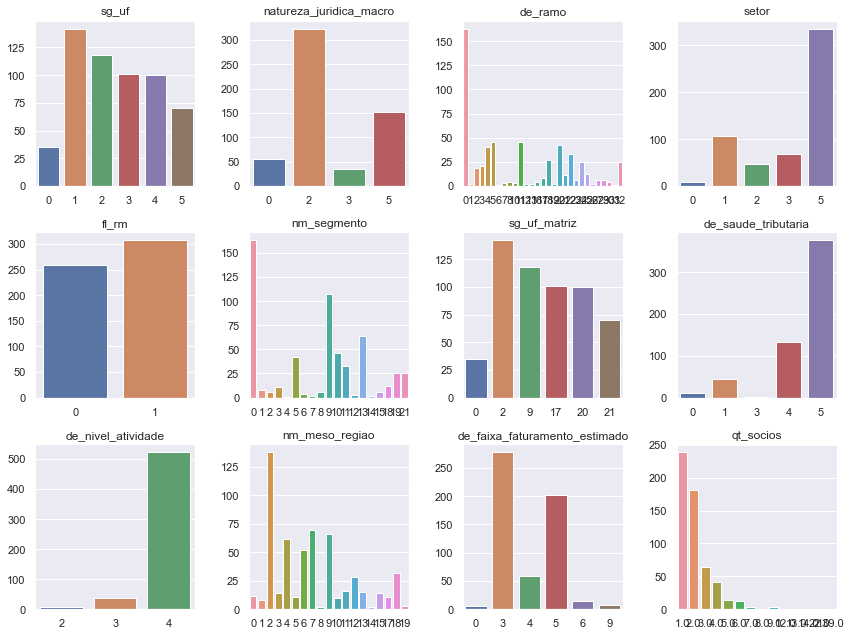

In [176]:
visualize_portfolio(portfolio2, columns2)

### Portfolio3

In [66]:
# I've already checked that portfolio2 and portfolio3 only have the id column
portfolio3 = pd.read_csv('portfolio3.csv').merge(market, on='id', how='inner')
portfolio3 = portfolio3.drop(portfolio3.columns[0], axis = 1)

In [67]:
portfolio3.head(1)

,id,sg_uf,natureza_juridica_macro,de_ramo,setor,fl_rm,nm_segmento,sg_uf_matriz,de_saude_tributaria,de_nivel_atividade,nm_meso_regiao,de_faixa_faturamento_estimado,qt_socios
0,bb61c09449a1c1f8b78955d8b7a7f73599e78358993fe2...,2,5,0,5,0,0,9,5,4,11,4,1.0


In [68]:
portfolio3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265 entries, 0 to 264
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             265 non-null    object 
 1   sg_uf                          265 non-null    int64  
 2   natureza_juridica_macro        265 non-null    int64  
 3   de_ramo                        265 non-null    int64  
 4   setor                          265 non-null    int64  
 5   fl_rm                          265 non-null    int64  
 6   nm_segmento                    265 non-null    int64  
 7   sg_uf_matriz                   265 non-null    int64  
 8   de_saude_tributaria            265 non-null    int64  
 9   de_nivel_atividade             265 non-null    int64  
 10  nm_meso_regiao                 265 non-null    int64  
 11  de_faixa_faturamento_estimado  265 non-null    int64  
 12  qt_socios                      265 non-null    flo

In [70]:
columns3 = portfolio3.columns[1:]

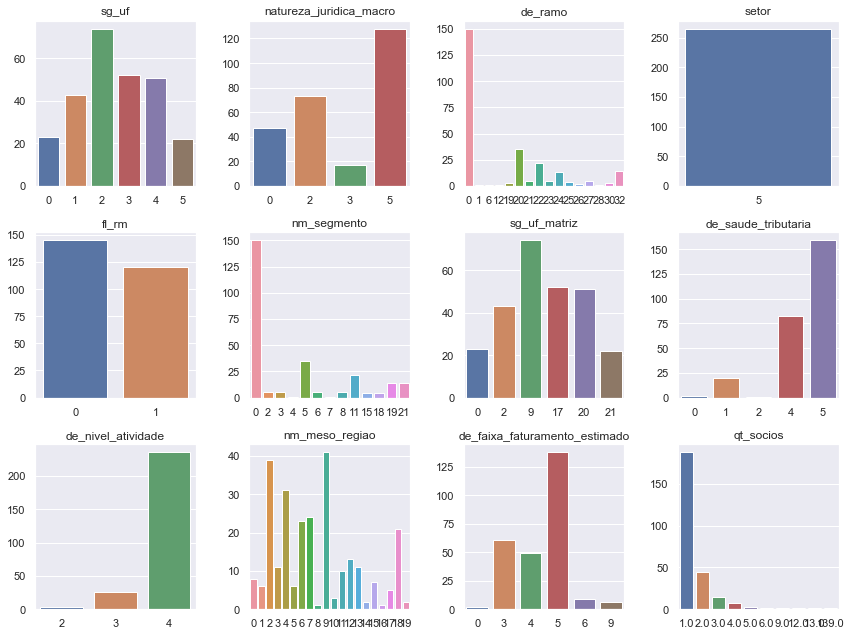

In [177]:
visualize_portfolio(portfolio3, columns3)

# Clustering the Portfolios

In [80]:
def market_client_clusters(market, portfolio, clusters=3):
    """ It clusters the portfolio according to the market dataset clustered
    
    Args:
    market: dataset
    portfolio: dataset
    clusters: int
    
    returns:
    market_clusters: dataset
    client: dataset
    """
    kmeans = KMeans(n_clusters=clusters, init='k-means++', max_iter=300, n_init=10)
    id_market = market['id']
    market = market.drop('id', axis=1)
    y_km=kmeans.fit_predict(market)
    
    market_cluster = pd.concat([id_market, pd.DataFrame(y_km)], axis=1)
    market_cluster.columns = ['id', 'cluster']
    client = market_cluster.merge(portfolio['id'], indicator=True, how='outer')
    client = client[client['_merge'] == 'both']
    return market_cluster, client

In [77]:
def portfolio_cluster(portfolio, clusters=3):
    kmeans = KMeans(n_clusters=clusters, init='k-means++', max_iter=300, n_init=10)
    id_portfolio = portfolio['id']
    portfolio = portfolio.drop('id', axis=1)
    y_km_port=kmeans.fit_predict(portfolio)
    port_cluster = pd.concat([id_portfolio, pd.DataFrame(y_km_port)], axis=1)
    port_cluster.columns = ['id', 'cluster']
    return port_cluster
    

### Portfolio 1

In [89]:
m_cluster, client_port1 = market_client_clusters(market, portfolio1, 5)

In [85]:
m_cluster['cluster'].value_counts()

1    137986
2    135360
3     78877
4     61719
0     48356
Name: cluster, dtype: int64

In [90]:
client_port1['cluster'].value_counts()

1    283
2    272
Name: cluster, dtype: int64

### Portfolio 2

In [92]:
m_cluster, client_port2 = market_client_clusters(market, portfolio2, 5)

In [93]:
client_port2['cluster'].value_counts()

3    180
1    174
2    115
0     72
4     25
Name: cluster, dtype: int64

### Portfolio 3

In [94]:
m_cluster, client_port3 = market_client_clusters(market, portfolio3, 5)

In [97]:
client_port3['cluster'].value_counts()

2    78
0    75
4    54
3    41
1    17
Name: cluster, dtype: int64

In [98]:
portfolio1.columns

Index(['id', 'sg_uf', 'natureza_juridica_macro', 'de_ramo', 'setor', 'fl_rm',
       'nm_segmento', 'sg_uf_matriz', 'de_saude_tributaria',
       'de_nivel_atividade', 'nm_meso_regiao', 'de_faixa_faturamento_estimado',
       'qt_socios'],
      dtype='object')

* Our model clustered the Portfolio1 into the clusters 1 and 2. 
* Portfolios 2 and 3 were well distributed into all clusters. 
* Analysing all the three portfolios, it's understandble that the first one is clustered only into two clusters. We can see by the visualisations that the number of unique values for Features such as `de_ramo`, `de_segmento`, which represents the market where the client is inserted, is smaller. It probably indicates that the Client1(Portfolio1) is probably newer in the field or it has a very biased market. 
* The clustering is a very good starting point for our recommendation system.

# KNN Recommendation Model

In [99]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [101]:
def restore_market(market_, base):
    market_ = market_.drop(columns=['cluster'])
    df_market = pd.merge(market_[['id']], base, on='id', how='inner')
    return df_market

In [102]:
def restore_client(client_, base):
    df_client_ = client_.drop(columns=['cluster', '_merge'])
    df_client_ = pd.merge(client_[['id']], base, on='id', how='inner')
    return df_client_

In [123]:
def simple_list(element_list):
    """
    Transforma a lista de listas em uma lista simples
    
    :param lista: lista de listas 
    """
    if isinstance(element_list, list):
        return [sub_elem for elem in element_list for sub_elem in simple_list(elem)]
    else:
        return [element_list]

In [100]:
def create_df_recommendation(list_index_knn, list_distances_knn, market, X_train):
    """
    Retorna um pd.Dataframe com os leads
    
    :param lista_indices_knn: lista de indices mais proximos
    :param lista_distancias_knn: lista das distancias de cada indice
    :param market: pd.Dataframe dataframe base
    """
    
    results = list(zip(list_index_knn, list_distances_knn))
    df_results = pd.DataFrame(results, columns=['indices', 'distancias'])
    
    top = df_results.groupby('indices').agg(count=('indices', 'count'), distances=('distancias', 'min'))\
                                    .sort_values(['count', 'distances'], ascending=[False, True]).index.values

    
    df_knn = market.loc[top].set_index('id')
    df_knn = df_knn[~df_knn.index.isin(X_train.index)]
    
    return df_knn

## Market

In [104]:
# splitting the market database for each cluster
market_0 = m_cluster[m_cluster.cluster == 0]
market_1 = m_cluster[m_cluster.cluster == 1]
market_2 = m_cluster[m_cluster.cluster == 2]
market_3 = m_cluster[m_cluster.cluster == 3]
market_4 = m_cluster[m_cluster.cluster == 4]

In [108]:
# creating a dataset for each market cluster
df0_market = restore_market(market_0, market)
df1_market = restore_market(market_1, market) 
df2_market = restore_market(market_2, market) 
df3_market = restore_market(market_3, market) 
df4_market = restore_market(market_4, market) 

In [109]:
def split_teste_treino(base_cliente, tamanho_teste):
    X_train, X_test, y_train, y_test = train_test_split(base_cliente, 
                                                                  list(range(len(base_cliente))),
                                                        test_size=tamanho_teste, random_state=1)
    return X_train, X_test

In [110]:
def neighbors_generator(X_train, knn):
    knn_index =  []
    knn_distances = []
    for i in range(X_train.shape[0]):
        distances, index = knn.kneighbors([X_train.loc[X_train.index[i]]], n_neighbors=5)
        knn_index.append(list(index[0]))
        knn_distances.append(list(distances[0]))
    return knn_index, knn_distances

In [150]:
def aggregate_funcs(market, client, client_restored):
    knn.fit(market.set_index('id'))
    knn_index, knn_distances = neighbors_generator(client_restored.set_index('id'), knn)
    list_knn_index = simple_list(knn_index)
    list_knn_distances = simple_list(knn_distances)
    recommendations = create_df_recommendation(list_knn_index, list_knn_distances, market, client)
    return recommendations

## Portfolio 1

In [112]:
cliente_port1['cluster'].value_counts()

2    283
1    272
Name: cluster, dtype: int64

In [113]:
client1_1 = client_port1[client_port1.cluster == 1]
client1_2 = client_port1[client_port1.cluster == 2]

In [118]:
dfc1_1 = restore_client(client1_1, market)
dfc1_2 = restore_client(client1_2, market)

In [151]:
mkt1 = aggregate_funcs(df1_market, client1_1, dfc1_1)

In [153]:
mkt2 = aggregate_funcs(df2_market, client1_2, dfc1_2)

In [155]:
print(f'Our model recommended {mkt1.shape[0]} companies from the cluster 1 and {mkt2.shape[0]} companies from the cluster 2')

Our model recommended 29 companies from the cluster 1 and 825 companies from the cluster 2


## Portfolio 2

In [156]:
client_port2['cluster'].value_counts()

3    180
1    174
2    115
0     72
4     25
Name: cluster, dtype: int64

In [165]:
client2_0 = client_port2[client_port2.cluster == 0]
client2_1 = client_port2[client_port2.cluster == 1]
client2_2 = client_port2[client_port2.cluster == 2]
client2_3 = client_port2[client_port2.cluster == 3]
client2_4 = client_port2[client_port2.cluster == 4]

In [166]:
dfc2_0 = restore_client(client2_0, market)
dfc2_1 = restore_client(client2_1, market)
dfc2_2 = restore_client(client2_2, market)
dfc2_3 = restore_client(client2_3, market)
dfc2_4 = restore_client(client2_4, market)

In [167]:
mkt2_0 = aggregate_funcs(df0_market, client2_0, dfc2_0)
mkt2_1 = aggregate_funcs(df1_market, client2_1, dfc2_1)
mkt2_2 = aggregate_funcs(df2_market, client2_2, dfc2_2)
mkt2_3 = aggregate_funcs(df3_market, client2_3, dfc2_3)
mkt2_4 = aggregate_funcs(df4_market, client2_4, dfc2_4)

In [168]:
print(f"""Our model recommended {mkt2_0.shape[0]} companies from the cluster 0
{mkt2_1.shape[0]} companies from the cluster 1
{mkt2_2.shape[0]} companies from the cluster 2
{mkt2_3.shape[0]} companies from the cluster 3
{mkt2_4.shape[0]} companies from the cluster 4""")

Our model recommended 134 companies from the cluster 0
134 companies from the cluster 1
169 companies from the cluster 2
113 companies from the cluster 3
36 companies from the cluster 4


## Portfolio 3

In [164]:
client_port3['cluster'].value_counts()

2    78
0    75
4    54
3    41
1    17
Name: cluster, dtype: int64

In [170]:
client3_0 = client_port3[client_port3.cluster == 0]
client3_1 = client_port3[client_port3.cluster == 1]
client3_2 = client_port3[client_port3.cluster == 2]
client3_3 = client_port3[client_port3.cluster == 3]
client3_4 = client_port3[client_port3.cluster == 4]

In [171]:
dfc3_0 = restore_client(client3_0, market)
dfc3_1 = restore_client(client3_1, market)
dfc3_2 = restore_client(client3_2, market)
dfc3_3 = restore_client(client3_3, market)
dfc3_4 = restore_client(client3_4, market)

In [172]:
mkt3_0 = aggregate_funcs(df0_market, client3_0, dfc3_0)
mkt3_1 = aggregate_funcs(df1_market, client3_1, dfc3_1)
mkt3_2 = aggregate_funcs(df2_market, client3_2, dfc3_2)
mkt3_3 = aggregate_funcs(df3_market, client3_3, dfc3_3)
mkt3_4 = aggregate_funcs(df4_market, client3_4, dfc3_4)

In [173]:
print(f"""Our model recommended {mkt3_0.shape[0]} companies from the cluster 0
{mkt3_1.shape[0]} companies from the cluster 1
{mkt3_2.shape[0]} companies from the cluster 2
{mkt3_3.shape[0]} companies from the cluster 3
{mkt3_4.shape[0]} companies from the cluster 4""")

Our model recommended 193 companies from the cluster 0
69 companies from the cluster 1
183 companies from the cluster 2
162 companies from the cluster 3
228 companies from the cluster 4


# Conclusions

* In this projected we were able to analyse a huge dataset with over 500k rows.
* We were able to understand and select the best features for our model.
* We could "break" the marke dataset into clusters making the processing faster.
* We were also able to recommend new companies for each portfolio based on an agnostic solution.

## What can we make better? 

* Work on metrics to evaluate the model.
* Build a prototype API and deploy it online. 